In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
X_normalized = pd.read_csv("crime_normalized_features.csv")
Y_normalized = pd.read_csv("crime_normalized_targets.csv")

# Replace "?" with NaN in both X and Y
X_normalized = X_normalized.replace("?", np.nan)
Y_normalized = Y_normalized.replace("?", np.nan)

# Prepare numeric dataframe with target included
numeric_df = X_normalized.apply(pd.to_numeric, errors='coerce')
target = pd.to_numeric(Y_normalized['ViolentCrimesPerPop'], errors='coerce')

# Combine temporarily ONLY to drop NaNs safely across both
combined = numeric_df.copy()
combined['ViolentCrimesPerPop'] = target

combined = combined.dropna(axis=1)

# This is the crucial fix. X must NOT contain the target.
Y = combined['ViolentCrimesPerPop']
X = combined.drop(columns=['ViolentCrimesPerPop'])


In [11]:
df = numeric_df.dropna(axis=1)

In [12]:
df

,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,8,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.00,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32
1,53,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.00,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00
2,24,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.00,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00
3,34,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.00,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00
4,42,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.00,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,...,0.00,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00
1990,6,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,...,0.00,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00
1991,9,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,...,0.02,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91
1992,25,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,...,0.01,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22


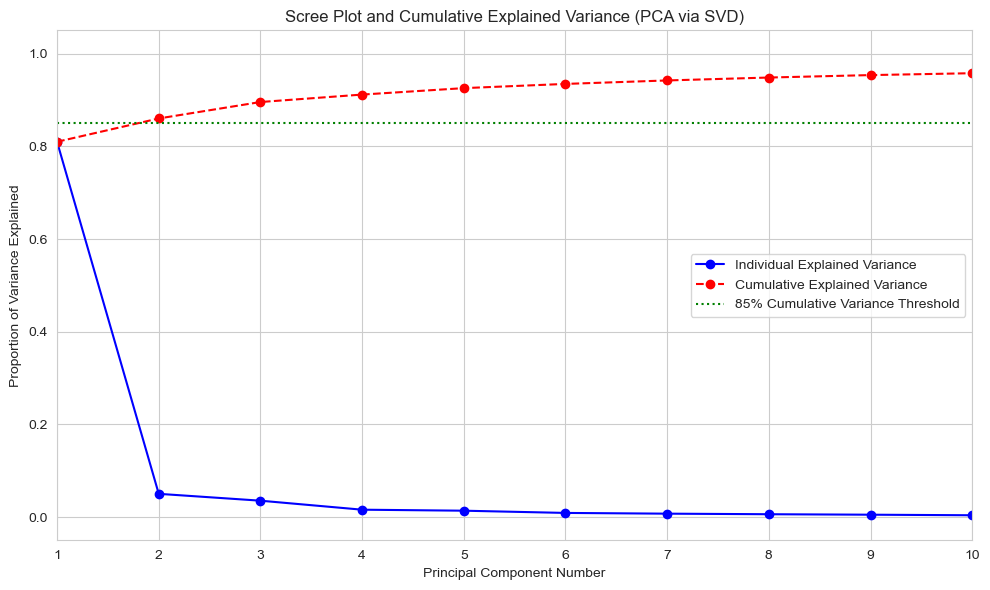

In [13]:
# Drop metadata columns that skew PCA
cols_to_drop = ['state', 'fold']
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

U, s, Vt = np.linalg.svd(X, full_matrices=False)
V = Vt.T

total_variance = np.sum(s**2)

# Calculate the variance explained by each component
explained_variance = s**2 / total_variance

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)


# 4. Generate the Scree Plot
# Create labels for the components
components = range(1, len(explained_variance) + 1)

# Set the style for the plot
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

# Plot the individual explained variance (Scree Plot)
plt.plot(components, explained_variance, marker='o', linestyle='-', color='b', label='Individual Explained Variance')

# Plot the cumulative explained variance
plt.plot(components, cumulative_explained_variance, marker='o', linestyle='--', color='r', label='Cumulative Explained Variance')

# Add a horizontal line at 95% cumulative variance (a common threshold)
plt.axhline(y=0.85, color='g', linestyle=':', label='85% Cumulative Variance Threshold')

# Labeling and title
plt.title('Scree Plot and Cumulative Explained Variance (PCA via SVD)')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance Explained')
plt.legend()
plt.grid(True)
plt.xlim(1, 10) # Set x-axis limit from 1 to the max number of components
plt.tight_layout()
plt.show()

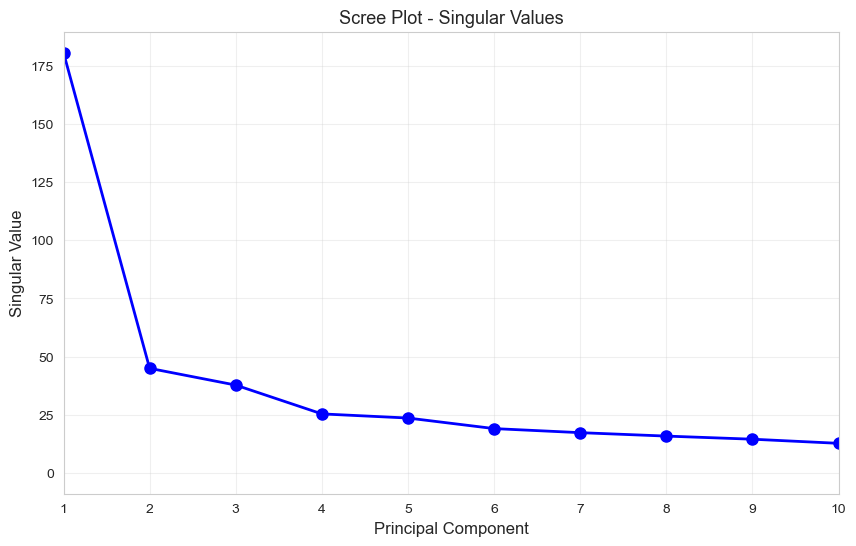

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(s) + 1), s, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Singular Value', fontsize=12)
plt.xlim(1, 10)
plt.title('Scree Plot - Singular Values', fontsize=13)
plt.grid(True, alpha=0.3)

In [15]:
# --- Top 10 Features Driving PC1 & PC2 ---

# 1. Get Loadings
# Vt rows are the principal components. We transpose to get features as rows.
# We only care about the first two components (columns 0 and 1 after transpose).
loadings = Vt[:2, :].T
feature_names = X.columns

# 2. Calculate "Strength" (Magnitude)
# Strength = sqrt(PC1_loading^2 + PC2_loading^2)
# This tells us how far the feature vector reaches in the PC1-PC2 plot.
magnitudes = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)

# 3. Create DataFrame
features_df = pd.DataFrame({
    'Feature': feature_names,
    'PC1_Loading': loadings[:, 0],
    'PC2_Loading': loadings[:, 1],
    'Strength': magnitudes
})

# 4. Sort by Strength and Get Top 10
top_10 = features_df.sort_values(by='Strength', ascending=False).head(10)

# 5. Display
print("Top 10 Features Driving PC1 and PC2:")
print(top_10[['Feature', 'Strength', 'PC1_Loading', 'PC2_Loading']].to_string(index=False))

Top 10 Features Driving PC1 and PC2:
         Feature  Strength  PC1_Loading  PC2_Loading
  PctPopUnderPov  0.226323    -0.072028    -0.214556
  PctHousNoPhone  0.224780    -0.062087    -0.216035
PctYoungKids2Par  0.223466    -0.166267     0.149305
     pctWPubAsst  0.215971    -0.076541    -0.201953
    racePctWhite  0.214301    -0.185782     0.106816
     PctKids2Par  0.212019    -0.155172     0.144477
    PctNotHSGrad  0.210145    -0.092831    -0.188529
      PctFam2Par  0.205259    -0.152911     0.136929
   PctUnemployed  0.201878    -0.087973    -0.181702
        pctUrban  0.200229    -0.176112     0.095270


['medIncome', 'MedRent', 'PctRecImmig10', 'PctKids2Par'] top picks

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Drop metadata columns that skew PCA
# We go back to 'combined' which was your clean dataframe before splitting
cols_to_drop = ['ViolentCrimesPerPop', 'state', 'fold']
X_clean = combined.drop(columns=[c for c in cols_to_drop if c in combined.columns])
Y_clean = combined['ViolentCrimesPerPop']

# 2. Re-run PCA (SVD) on the clean data
U_clean, s_clean, Vt_clean = np.linalg.svd(X_clean, full_matrices=False)

# Calculate variance ratios again
total_variance_clean = np.sum(s_clean**2)
explained_variance_clean = s_clean**2 / total_variance_clean
cumulative_variance_clean = np.cumsum(explained_variance_clean)

# 3. Transform X into PCA components
X_pca_clean = U_clean @ np.diag(s_clean)

# Select components explaining 95% variance
k_clean = np.argmax(cumulative_variance_clean >= 0.85) + 1
X_pca_selected_clean = X_pca_clean[:, :k_clean]

print(f"Number of components selected (85% variance): {k_clean}")

# 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_pca_selected_clean, Y_clean, test_size=0.2, random_state=42)

# 5. Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict & Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression with Corrected PCA:")
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

Number of components selected (85% variance): 2
Linear Regression with Corrected PCA:
MSE: 0.0264
R2 Score: 0.4492


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Convert Target to Binary Class (High vs Low Crime)
# Since the target is continuous, we need to binarize it for Logistic Regression.
# We'll use the median as the threshold: 1 if > median, 0 otherwise.
threshold = Y_clean.median()
y_binary = (Y_clean > threshold).astype(int)

print(f"Binary Classification Threshold (Median): {threshold:.4f}")

# 2. Split Data (using the same PCA components from the previous step)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_pca_selected_clean, y_binary, test_size=0.2, random_state=42
)

# 3. Train Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train_log, y_train_log)

# 4. Predict
y_pred_log = log_model.predict(X_test_log)

# 5. Evaluate
print(f"Logistic Regression Accuracy: {accuracy_score(y_test_log, y_pred_log):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_log, y_pred_log))

Binary Classification Threshold (Median): 0.1500
Logistic Regression Accuracy: 0.7293

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       224
           1       0.69      0.70      0.69       175

    accuracy                           0.73       399
   macro avg       0.73      0.73      0.73       399
weighted avg       0.73      0.73      0.73       399



In [20]:
# --- Compare Linear vs Logistic Regression ---

# 1. Convert Linear Regression Predictions to Binary
# We use the same threshold (median) to classify the continuous predictions
y_pred_linear_binary = (y_pred > threshold).astype(int)

# 2. Calculate Accuracy for Linear Regression (as a classifier)
# We must also binarize the true values (y_test) which are continuous
y_test_binary = (y_test > threshold).astype(int)

linear_accuracy = accuracy_score(y_test_binary, y_pred_linear_binary)
logistic_accuracy = accuracy_score(y_test_log, y_pred_log)

print("--- Model Comparison ---")
print(f"Linear Regression (Thresholded) Accuracy: {linear_accuracy:.4f}")
print(f"Logistic Regression Accuracy:             {logistic_accuracy:.4f}")

if logistic_accuracy > linear_accuracy:
    print("\nLogistic Regression performed better.")
else:
    print("\nLinear Regression (Thresholded) performed better.")

--- Model Comparison ---
Linear Regression (Thresholded) Accuracy: 0.6867
Logistic Regression Accuracy:             0.7293

Logistic Regression performed better.


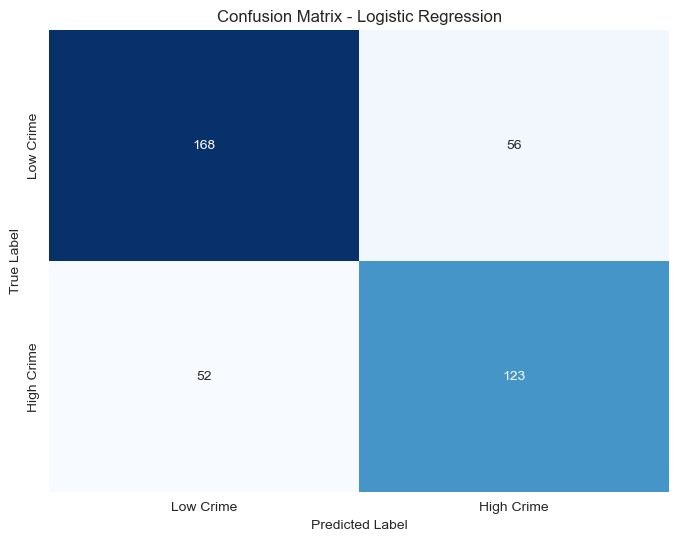

In [19]:
# --- Confusion Matrix Heatmap (Logistic Regression) ---

cm = confusion_matrix(y_test_log, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low Crime', 'High Crime'],
            yticklabels=['Low Crime', 'High Crime'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()